In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie
  
  CairoMakie.activate!(type = string(fig_format))
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/home/ludo/ownCloud/Programmes/julia/biomaths_julia_www"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
using DifferentialEquations, Plots, DataFrames

# paramètres
r = 5.0      # natalité
K = 10.0     # mortalité
α = 1.0      # taux max de prédation
h = 0.5      # constante de demi-saturation

ϵ = 0.01     # timescale
n = 5.0      # gain à la prédation
m = 3.0      # moralité


par_tord_ois = [r, K, α, h, ϵ, n, m] 

# temps d'intégration
tspan = (0.0, 400.0)
tstep = 0.02

# conditions initiales
x0 = 1.0    # tordeuses
y0 = 2.5    # oiseaux
etat0 = [x0, y0]

2-element Vector{Float64}:
 1.0
 2.5

In [3]:
function tord_ois(u, param, t)
    r, K, α, h, ϵ, n, m = param
    x = u[1]
    y = u[2]
    dx = r*x*(1 - x/K) - α*x^2/(h^2 + x^2) * y
    dy = ϵ*(n*α*x^2/(h^2 + x^2) * y - m * y)
    [dx, dy]
end

tord_ois (generic function with 1 method)

In [4]:
prob_tord_ois = ODEProblem(tord_ois, 
                           etat0, 
                           tspan, 
                           par_tord_ois, 
                           saveat = tstep)

sol_tord_ois = solve(prob_tord_ois, reltol = 1e-6)

sol_tord_ois = DataFrame(sol_tord_ois)
rename!(sol_tord_ois, :timestamp => :time, :value1 => :x, :value2 => :y)

Row,time,x,y
,Float64,Float64,Float64
1,0.0,1.0,2.5
2,0.02,1.05164,2.50052
3,0.04,1.10671,2.50108
4,0.06,1.16549,2.50167
5,0.08,1.22822,2.5023
6,0.1,1.29519,2.50296
7,0.12,1.36667,2.50365
8,0.14,1.44293,2.50437
9,0.16,1.52427,2.50512


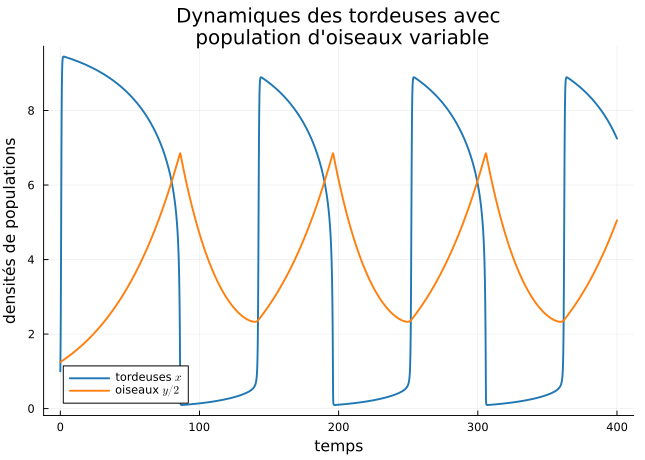

In [5]:
#| output: true
# color definitions
mygreen = palette(:tab10)[3]
myorange = palette(:tab10)[2]
myblue = palette(:tab10)[1]
myred = palette(:tab10)[4]

P1 = plot(sol_tord_ois.time, sol_tord_ois.x,
          color = myblue,
          linewidth = 2,
          label = "tordeuses \$x\$",
          xlabel = "temps",
          ylabel = "densités de populations",
          title = "Dynamiques des tordeuses avec\n population d'oiseaux variable")

plot!(P1, sol_tord_ois.time, sol_tord_ois.y ./ 2,
      color = myorange,
      linewidth = 2,
      label = "oiseaux \$y/2\$")

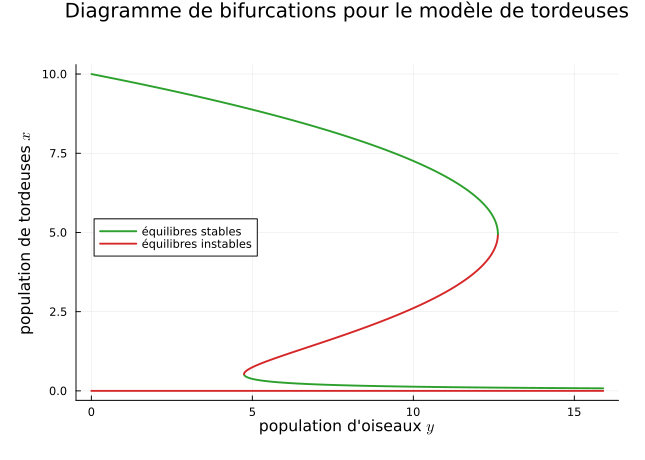

In [6]:
#| code-fold: true
using Symbolics, Polynomials

@variables X
D = Differential(X)

# lieu des équilibres positifs
Y = r/(α*X)*(1-X/K)*(h^2+X^2)

# dénominateur de la dérivée
dnumerator = Symbolics.arguments(Symbolics.value(simplify(expand_derivatives(D(Y)))))[1]

# on récupère les coefficients X^k du polynôme
coefs_dict = Symbolics.value(dnumerator).dict
dd = Dict(Symbolics.degree(first(kv)) => kv[2] for kv ∈ coefs_dict)
# on rajoute dans le dictionnaire le coefficient constant
dd[0] = substitute(dnumerator, Dict(X=>0))

# on définit le polynôme à partir du dictionnaire
dnumpoly = SparsePolynomial(dd, :X)

# on calcule les racines en filtrant les racines entre 0 et K via une fonction anonyme s-> K > s > 0
droots = filter(s -> K > s > 0, roots(dnumpoly))

# vecteur pour le tracé du diagramme de bifurcation
xplot1 = 0.08:.01:droots[1]
xplot2 = droots[1]:.01:droots[2]
xplot3 = droots[2]:.01:K
yeq1 = r.*(1 .-xplot1./K) ./ (α.*xplot1).*(h^2 .+xplot1.^2)
yeq2 = r.*(1 .-xplot2./K) ./ (α.*xplot2).*(h^2 .+xplot2.^2)
yeq3 = r.*(1 .-xplot3./K) ./ (α.*xplot3).*(h^2 .+xplot3.^2)

# diagramme de bifurcations
Pbif = plot(yeq1, xplot1,
            linewidth = 2,
            color = mygreen,
            label = "équilibres stables",
            legend = :left,
            xlabel = "population d'oiseaux \$y\$",
            ylabel = "population de tordeuses \$x\$",
            title = "Diagramme de bifurcations pour le modèle de tordeuses",
            margin = .5Plots.cm,
            topmargin = 1Plots.cm)

plot!(Pbif, yeq2, xplot2,
      linewidth = 2,
      color = myred,
      label = "équilibres instables")

plot!(Pbif, yeq3, xplot3,
      linewidth = 2,
      color = mygreen,
      label = "")

plot!(Pbif, [0, maximum(yeq1)], [0, 0], 
      color = myred,
      lw = 2,
      label = "")

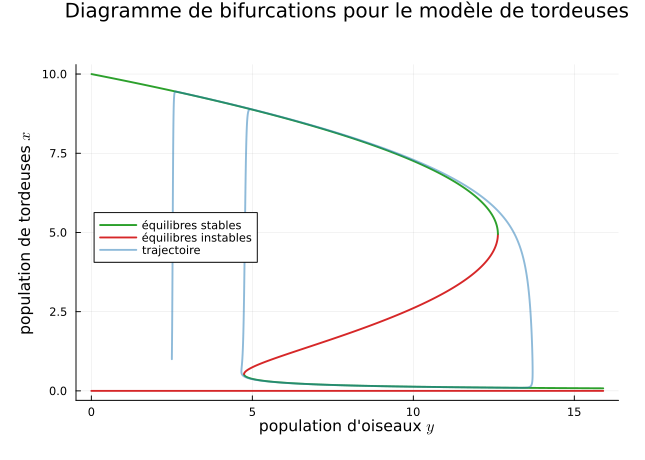

In [7]:
#| output: true
plot!(Pbif, sol_tord_ois.y, sol_tord_ois.x,
      color = myblue,
      linewidth = 2,
      linealpha = 0.5,
      label = "trajectoire")

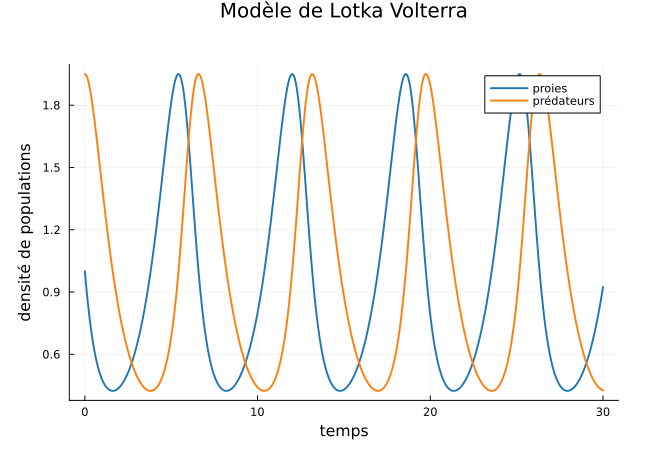

In [8]:
#| output: true
#| code-fold: true
# conditions initiales
x0 = 1.0
y0 = 1.95
etat0 = [x0, y0]

# paramètres
r = 1.0
c = 1.0
b = 1.0
m = 1.0
par_lovo = [r, c, b, m]

# integration plus longue
tspan = (0.0, 30.0)
tstep = .01

# définition du modèle
function lovo(u, par, t)
    r, c, b, m = par
    x = u[1]
    y = u[2]
    dx = r*x - c*x*y
    dy = b*x*y - m*y
    [dx, dy]
end

# problème
prob_lovo = ODEProblem(lovo, etat0, tspan, par_lovo, saveat = tstep)
# intégration
sol_lovo = solve(prob_lovo, reltol = 1e-6)
# dataframe
sol_lovo = DataFrame(sol_lovo)
rename!(sol_lovo, :timestamp => :time, :value1 => :x, :value2 => :y)

Plv = plot(sol_lovo.time, sol_lovo.x,
           linewidth = 2,
           color = myblue,
           label = "proies",
           xlabel = "temps",
           ylabel = "densité de populations",
           title = "Modèle de Lotka Volterra",
           margin = .5Plots.cm,
           topmargin = 1Plots.cm)

plot!(Plv, sol_lovo.time, sol_lovo.y,
      linewidth = 2,
      color = myorange,
      label = "prédateurs")

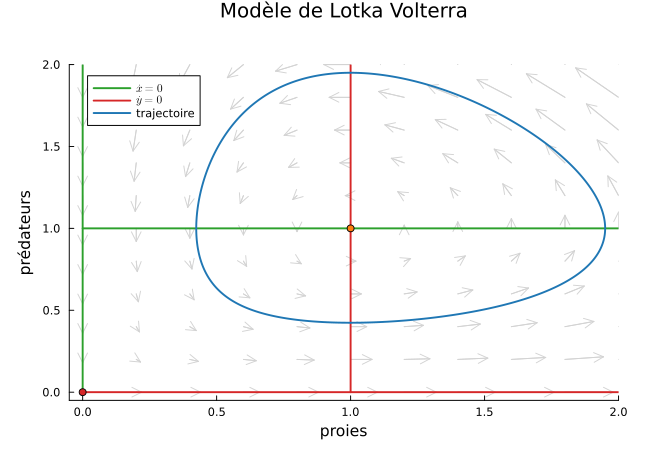

In [9]:
#| output: true
#| label: fig-phase-lovo
#| fig-cap: Plan de phase du modèle de Lotka Volterra
# on redéfinit des fonctions qui renvoient les composantes de la dérivée mises à l'échelle
scale = 10
der_x(x, y) = lovo([x y], par_lovo, 0)[1]/scale
der_y(x, y) = lovo([x y], par_lovo, 0)[2]/scale

# on définit un ensemble de valeur de x et y formant une grille 
# sur laquelle évaluer le champs de vecteurs
xrange = range(0., 2, length=11)'  # note ' : on va broadcaster pour créer la grille via der_x.() et der_y.()
yrange = range(0. ,2, length=11)

# champs de vecteurs
Plan = quiver(xrange, yrange, 
       quiver = (der_x.(xrange, yrange), der_y.(xrange, yrange)),
       ylim = (-0.05, 2),
       xlim = (-0.05, 2),
       color = :lightgray,
	 grid = false,
       title = "Modèle de Lotka Volterra",
       xlabel = "proies",
       ylabel = "prédateurs",
       margin = .5Plots.cm,
       topmargin = 1Plots.cm)

# isoclines nulles
xplot = 0:2
yplot = 0:2
plot!(Plan, xplot, ones(length(xplot)).*r./c,
      linewidth = 2,
      color = mygreen,
      label = "\$\\dot x = 0\$")
plot!(Plan, zeros(length(yplot)), yplot,
      linewidth = 2,
      color = mygreen,
      label = "")
plot!(Plan, ones(length(yplot)).*m./b, yplot,
      linewidth = 2,
      color = myred,
      label = "\$\\dot y = 0\$")
plot!(Plan, xplot, zeros(length(xplot)), 
      linewidth = 2,
      color = myred,
      label = "")

# équilibres
plot!(Plan, (0, 0),
      markershape = :circle,
      color= myred,
      label = "")
plot!(Plan, (m/b, r/c),
      markershape = :circle,
      color= myorange,
      label = "")

# trajectoire
plot!(Plan,  sol_lovo.x, sol_lovo.y,
      color = myblue,
      linewidth = 2,
      label = "trajectoire")